# Experiment 1.B: LDA Autoencoding Variational Bayes

```
Author:
Zach Wolpe
zachcolinwolpe@gmail.com
www.zachwolpe.com
```

Identical to Experiment 1.A - however utilizing Autoencoding for the LDA learning model.

In [1]:
%matplotlib inline
import sys, os
%env THEANO_FLAGS=device=cpu,floatX=float64
import theano


from collections import OrderedDict
from copy import deepcopy
import numpy as np
import pandas as pd
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
import seaborn as sns
from theano import shared
import theano.tensor as tt
from theano.sandbox.rng_mrg import MRG_RandomStreams

import pymc3 as pm
from pymc3 import math as pmmath
from pymc3 import Dirichlet
from pymc3.distributions.transforms import t_stick_breaking
plt.style.use('seaborn-darkgrid')

import warnings
warnings.filterwarnings("ignore")

import warnings
warnings.filterwarnings("ignore")

env: THEANO_FLAGS=device=cpu,floatX=float64


# Data Preprocessing

To eliminate the possibility of decrepencies in model performance arising from unrelated differences, the same dataset & processing techniques are employed as _'Experiment 1.a'_.


### Dataset
I've used a sub-section of the _20 News Groups_ dataset (a dataset containing news headlines). This subset contains 11'000 headlines. This version of the dataset contains about 11k newsgroups posts from 20 different topics.

The topics are labeled and as such we can compare topics with forecasted results.


## Extensive Text Processing - Gensim

### Download dataset and stopwords

##### Example dataset:
I've used a sub-section of the _20 News Groups_ dataset (a dataset containing news headlines). This subset contains 11'000 headlines. This version of the dataset contains about 11k newsgroups posts from 20 different topics.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os
import theano
from time import time
import re
from pprint import pprint

# nltk
import nltk
from nltk.corpus import stopwords

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

In [3]:
# download stopwords
nltk.download('stopwords')

# NLTK Stop words
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])


# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zachcolinwolpe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['rec.autos' 'comp.sys.mac.hardware' 'rec.motorcycles' 'misc.forsale'
 'comp.os.ms-windows.misc' 'alt.atheism' 'comp.graphics'
 'rec.sport.baseball' 'rec.sport.hockey' 'sci.electronics' 'sci.space'
 'talk.politics.misc' 'sci.med' 'talk.politics.mideast'
 'soc.religion.christian' 'comp.windows.x' 'comp.sys.ibm.pc.hardware'
 'talk.politics.guns' 'talk.religion.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles
100,From: tchen@magnus.acs.ohio-state.edu (Tsung-K...,6,misc.forsale
1000,From: dabl2@nlm.nih.gov (Don A.B. Lindbergh)\n...,2,comp.os.ms-windows.misc


## Remove emails and newline characters

In [4]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

print(data[:1])

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: 15 I was wondering if anyone out there could enlighten me on this car I saw the other day. It was a 2-door sports car, looked to be from the late 60s/ early 70s. It was called a Bricklin. The doors were really small. In addition, the front bumper was separate from the rest of the body. This is all I know. If anyone can tellme a model name, engine specs, years of production, where this car is made, history, or whatever info you have on this funky looking car, please e-mail. Thanks, - IL ---- brought to you by your neighborhood Lerxst ---- ']


## Tokenize words and Clean-up text

In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


## Creating Bigram and Trigram Models

Two words that frequently occur together form a bigram, three a trigram.

Gensim’s Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are _min_count_ and _threshold_. The higher the values of these param, the harder it is for words to be combined to bigrams.

In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


## Remove Stopwords, Make Bigrams and Lemmatize

The bigrams model is ready. Let’s define the functions to remove the stopwords, make bigrams and lemmatization and call them sequentially.

In [7]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [8]:
# call the above functions

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['where', 's', 'thing', 'car', 'nntp_poste', 'host', 'umd', 'organization', 'university', 'maryland_college', 'park', 'line', 'wonder', 'anyone', 'could', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'bricklin', 'door', 'really', 'small', 'addition', 'front_bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'specs', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


## Create the Dictionary and Corpus needed for Topic Modeling

The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them.

Now the dictionary and term freq matrix are ready to feed into a model

In [9]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 5), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1)]]


## LDA Comparison

In conducting a variation bayes experimentation, utilising the small - approx 11'000 doc - corpus (of 20 newsgroups), I will compare Gensim LDA vs AEVB based on the following metrix:
    - coherence score
    - computational speed
    - topic inspection (top 10 elements)
    - Hungarian method
    
# AutoEncoding LDA implementations

Fitting the LDA using an Autoencoder.

## Term frequency document
The original Auto-Encoder tutorial utilizes a term frequence document for training however a slightly different document structure is used here. 

The processed text documennts are now converted back to text corpus, however keeping the processed tokens as apposed to the original unprocessed words.

In [10]:
# Create the term freq doc
data = pd.Series(data_lemmatized)

data = pd.Series([" ".join(i) for i in data])

data.head()

0    where s thing car nntp_poste host umd organiza...
1    clock poll final call summary final call si cl...
2    irwin arnstein recommendation duc summary s wo...
3    tsung kun chen software forsale lot nntp_poste...
4    lindbergh diamond_ss win mouse_cursor organiza...
dtype: object

# Alternative Dataset

Consider another dataset:

Employee Reviews from FANG companies. 120 datapoints contain no 'summary' - and are disgarded.

In [11]:
reviews = pd.read_csv('../datasets/employee_reviews.csv')
reviews = reviews[reviews.summary.notnull()]

summary = reviews.summary

print(reviews.shape)
reviews.head()

(67409, 17)


,Unnamed: 0,company,location,dates,job-title,summary,pros,cons,advice-to-mgmt,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars,helpful-count,link
0,1,google,none,"Dec 11, 2018",Current Employee - Anonymous Employee,Best Company to work for,People are smart and friendly,Bureaucracy is slowing things down,none,5.0,4.0,5.0,5.0,4.0,5.0,0,https://www.glassdoor.com/Reviews/Google-Revie...
1,2,google,"Mountain View, CA","Jun 21, 2013",Former Employee - Program Manager,"Moving at the speed of light, burn out is inev...","1) Food, food, food. 15+ cafes on main campus ...",1) Work/life balance. What balance? All those ...,1) Don't dismiss emotional intelligence and ad...,4.0,2.0,3.0,3.0,5.0,3.0,2094,https://www.glassdoor.com/Reviews/Google-Revie...
2,3,google,"New York, NY","May 10, 2014",Current Employee - Software Engineer III,Great balance between big-company security and...,"* If you're a software engineer, you're among ...","* It *is* becoming larger, and with it comes g...",Keep the focus on the user. Everything else wi...,5.0,5.0,4.0,5.0,5.0,4.0,949,https://www.glassdoor.com/Reviews/Google-Revie...
3,4,google,"Mountain View, CA","Feb 8, 2015",Current Employee - Anonymous Employee,The best place I've worked and also the most d...,You can't find a more well-regarded company th...,I live in SF so the commute can take between 1...,Keep on NOT micromanaging - that is a huge ben...,5.0,2.0,5.0,5.0,4.0,5.0,498,https://www.glassdoor.com/Reviews/Google-Revie...
4,5,google,"Los Angeles, CA","Jul 19, 2018",Former Employee - Software Engineer,"Unique, one of a kind dream job",Google is a world of its own. At every other c...,"If you don't work in MTV (HQ), you will be giv...",Promote managers into management for their man...,5.0,5.0,5.0,5.0,5.0,5.0,49,https://www.glassdoor.com/Reviews/Google-Revie...


## Create term frequency document 

The redesigned corpus is now vectorized to produce a sparse term-frequency matrix.

We are able to limit the number of words here.



In [ ]:
from sklearn.feature_extraction.text import CountVectorizer


# processed data
# data

# try with raw data
# df

n_words = round(corpus[-1][-1][0], -4) # Na      # total number of words in the gensim dictionary / corpus
n_words = 37724 #NA 
# n_words = 30000

In [4]:
# The number of words in the vocabulary
n_words = 1000

print("Loading dataset...")
t0 = time()
dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'))
data_samples = dataset.data
print("done in %0.3fs." % (time() - t0))



# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_words,
                                stop_words='english')

t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
feature_names = tf_vectorizer.get_feature_names()
print("done in %0.3fs." % (time() - t0))

Loading dataset...
done in 2.738s.
Extracting tf features for LDA...
done in 3.509s.


## Train-test split
Split the data to improve reliability of results

In [5]:
# We split the whole documents into training and test sets. 
# The number of tokens in the training set is 480K. 
# Sparsity of the term-frequency document matrix is 0.025%, which implies almost all components in the term-frequency matrix is zero


n_samples_tr = round(tf.shape[0] * 0.7) # testing on 70%
n_samples_te = tf.shape[0] - n_samples_tr
docs_tr = tf[:n_samples_tr, :]
docs_te = tf[n_samples_tr:, :]
print('Number of docs for training = {}'.format(docs_tr.shape[0]))
print('Number of docs for testing = {}'.format(docs_te.shape[0]))


n_tokens = np.sum(docs_tr[docs_tr.nonzero()])
print('Number of tokens in training set = {}'.format(n_tokens))
print('Sparsity = {}'.format(
    len(docs_tr.nonzero()[0]) / float(docs_tr.shape[0] * docs_tr.shape[1])))

Number of docs for training = 7920
Number of docs for testing = 3394
Number of tokens in training set = 384502
Sparsity = 0.0255030303030303


# Log-likelihood of documents for LDA

In [6]:
def logp_lda_doc(beta, theta):
  
  """Returns the log-likelihood function for given documents.
  
  K : number of topics in the model
  V : number of words (size of vocabulary)
  D : number of documents (in a mini-batch)
  
  Parameters
  ----------
  beta : tensor (K x V)
      Word distribution.
  theta : tensor (D x K)
      Topic distributions for the documents.
  """
  
  def ll_docs_f(docs):
    
    dixs, vixs = docs.nonzero()
    vfreqs = docs[dixs, vixs]
    ll_docs = vfreqs * pmmath.logsumexp(
          tt.log(theta[dixs]) + tt.log(beta.T[vixs]), axis=1).ravel()
      
    # Per-word log-likelihood times no. of tokens in the whole dataset
    return tt.sum(ll_docs) / (tt.sum(vfreqs)+1e-9) * n_tokens

  return ll_docs_f

# Fit the LDA

In [7]:
n_topics = 10

# we have sparse dataset. It's better to have dence batch so that all words accure there
minibatch_size = 128

# defining minibatch
doc_t_minibatch = pm.Minibatch(docs_tr.toarray(), minibatch_size)
doc_t = shared(docs_tr.toarray()[:minibatch_size])

with pm.Model() as model:
  theta = Dirichlet('theta', a=pm.floatX((1.0 / n_topics) * np.ones((minibatch_size, n_topics))),
                   shape=(minibatch_size, n_topics), transform=t_stick_breaking(1e-9),
                   # do not forget scaling
                   total_size = n_samples_tr)
  beta = Dirichlet('beta', a=pm.floatX((1.0 / n_topics) * np.ones((n_topics, n_words))),
                 shape=(n_topics, n_words), transform=t_stick_breaking(1e-9))
  # Note, that we defined likelihood with scaling, so here we need no additional `total_size` kwarg
  doc = pm.DensityDist('doc', logp_lda_doc(beta, theta), observed=doc_t)

# Encoder

In [8]:
class LDAEncoder:
  """Encode (term-frequency) document vectors to variational means and (log-transformed) stds.
  """
  def __init__(self, n_words, n_hidden, n_topics, p_corruption=0, random_seed=1):
    rng = np.random.RandomState(random_seed)
    self.n_words = n_words
    self.n_hidden = n_hidden
    self.n_topics = n_topics
    self.w0 = shared(0.01 * rng.randn(n_words, n_hidden).ravel(), name='w0')
    



class LDAEncoder:
    """Encode (term-frequency) document vectors to variational means and (log-transformed) stds.
    """
    def __init__(self, n_words, n_hidden, n_topics, p_corruption=0, random_seed=1):
        rng = np.random.RandomState(random_seed)
        self.n_words = n_words
        self.n_hidden = n_hidden
        self.n_topics = n_topics
        self.w0 = shared(0.01 * rng.randn(n_words, n_hidden).ravel(), name='w0')
        self.b0 = shared(0.01 * rng.randn(n_hidden), name='b0')
        self.w1 = shared(0.01 * rng.randn(n_hidden, 2 * (n_topics - 1)).ravel(), name='w1')
        self.b1 = shared(0.01 * rng.randn(2 * (n_topics - 1)), name='b1')
        self.rng = MRG_RandomStreams(seed=random_seed)
        self.p_corruption = p_corruption

    def encode(self, xs):
        if 0 < self.p_corruption:
            dixs, vixs = xs.nonzero()
            mask = tt.set_subtensor(
                tt.zeros_like(xs)[dixs, vixs],
                self.rng.binomial(size=dixs.shape, n=1, p=1-self.p_corruption)
            )
            xs_ = xs * mask
        else:
            xs_ = xs

        w0 = self.w0.reshape((self.n_words, self.n_hidden))
        w1 = self.w1.reshape((self.n_hidden, 2 * (self.n_topics - 1)))
        hs = tt.tanh(xs_.dot(w0) + self.b0)
        zs = hs.dot(w1) + self.b1
        zs_mean = zs[:, :(self.n_topics - 1)]
        zs_rho = zs[:, (self.n_topics - 1):]
        return {'mu': zs_mean, 'rho':zs_rho}

    def get_params(self):
        return [self.w0, self.b0, self.w1, self.b1]

In [9]:
tf.shape
np.mean(np.sum(tf, axis=1))

48.641329326498145

In [10]:
encoder = LDAEncoder(n_words=n_words, n_hidden=100, n_topics=n_topics, p_corruption=0.0)
local_RVs = OrderedDict([(theta, encoder.encode(doc_t))])
local_RVs

OrderedDict([(theta,
              {'mu': Subtensor{::, :int64:}.0,
               'rho': Subtensor{::, int64::}.0})])

In [11]:
encoder_params = encoder.get_params()
encoder_params

[w0, b0, w1, b1]

# AEVB with ADVI

# Additional Callback

In [12]:
tacker_thetas = []
tacker_betas = []
tacker_thetas_1 = []

def my_callback(a,h,i):
    tacker_thetas.append(pm.sample_approx(approx, draws=20000)['theta'].mean(axis=0))
    tacker_thetas_1.append(pm.sample_approx(approx, draws=1)['theta'].mean(axis=0))
    a = a
    h = h
    i = i 
    
  #   tacker_betas.append(approx.model.beta)

In [15]:
η = .1
s = shared(η)
def reduce_rate(a, h, i):
    s.set_value(η/((i/minibatch_size)+1)**.7)

with model:
    approx = pm.MeanField(local_rv=local_RVs)
    approx.scale_cost_to_minibatch = False
    inference = pm.KLqp(approx)
inference.fit(5, callbacks=[reduce_rate, my_callback], obj_optimizer=pm.sgd(learning_rate=s),
              more_obj_params=encoder_params, total_grad_norm_constraint=200,
              more_replacements={doc_t:doc_t_minibatch})

Average Loss = 3.3176e+06: 100%|██████████| 5/5 [23:32<00:00, 295.70s/it]
Finished [100%]: Loss = 3.1216e+06


In [23]:
np.array(tacker_thetas_1[0][0])

array([3.23173479e-09, 1.89343867e-09, 9.99999994e-01, 3.85012306e-15,
       1.00024939e-18, 1.99809576e-14, 3.57581826e-11, 3.86070885e-11,
       9.25610974e-10, 9.25611051e-19])

In [33]:
np.round(tacker_thetas_1[0][0], 5)

for j in range(len(tacker_thetas_1)):
    
    print('__break___')
    
    for i in range(len(tacker_thetas_1)):
        print(np.round(tacker_thetas_1[j][i], 5))

__break___
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0.52521 0.47479 0.      0.      0.      0.      0.      0.      0.
 0.     ]
[0.13497 0.      0.86503 0.      0.      0.      0.      0.      0.
 0.     ]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
__break___
[1.0000e-05 4.0000e-05 1.9905e-01 0.0000e+00 8.0091e-01 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
[2.0000e-05 0.0000e+00 5.6290e-02 9.4368e-01 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
[2.0000e-05 1.0000e-05 4.4000e-04 0.0000e+00 9.9008e-01 9.4400e-03
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
[2.0000e-05 0.0000e+00 6.0360e-01 3.9638e-01 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
[1.0000e-05 0.0000e+00 4.1910e-02 1.0000e-04 9.5797e-01 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
__break___
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.01976 0.98024 0.      0.      0.      0.      0.   

In [22]:
print(approx)

Approximation{MeanFieldGroup[None, 9] & MeanFieldGroup[9990]}


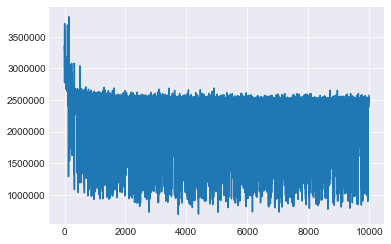

In [23]:
plt.plot(approx.hist[10:]);

# Extraction of characteristic words of topics based on posterior samples

In [24]:
def print_top_words(beta, feature_names, n_top_words=10):
    for i in range(len(beta)):
        print(("Topic #%d: " % i) + " ".join([feature_names[j]
            for j in beta[i].argsort()[:-n_top_words - 1:-1]]))


doc_t.set_value(docs_tr.toarray())
samples = pm.sample_approx(approx, draws=100)
beta_pymc3 = samples['beta'].mean(axis=0)

print_top_words(beta_pymc3, feature_names)

Topic #0: use file windows key program drive does bit using like
Topic #1: people god think don just know like say time said
Topic #2: 00 10 11 15 20 db 12 55 16 17
Topic #3: ax max g9v b8f 75u a86 1t bhj 145 pl
Topic #4: just like good don car time year think game team
Topic #5: edu space com information nasa mail anonymous new university data
Topic #6: know don just like think does people use good thanks
Topic #7: know just like don does thanks good mail ve think
Topic #8: know don like just does thanks think good new edu
Topic #9: like know just don does thanks good think new edu


# Compare with Sklearn

In [25]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5,
                                learning_method='online', learning_offset=50.,
                                random_state=0)
%time lda.fit(docs_tr)
beta_sklearn = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]

print_top_words(beta_sklearn, feature_names)

/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


CPU times: user 1min 2s, sys: 1.45 s, total: 1min 4s
Wall time: 46.4 s
Topic #0: gun people armenian armenians turkish state states said 000 war
Topic #1: mr law people government use don president stephanopoulos right know
Topic #2: space nasa data program output launch science research entry earth
Topic #3: key car chip keys used clipper bit bike use wire
Topic #4: edu file com mail available files information ftp image list
Topic #5: god people does jesus believe think say don know just
Topic #6: windows db drive use thanks does problem know card like
Topic #7: ax max g9v pl b8f 75u a86 bhj 1t 34u
Topic #8: just don like think know time good people ve didn
Topic #9: 00 10 15 20 12 11 50 16 25 new


In [26]:
# save sklearn model
from sklearn.externals import joblib
joblib.dump(lda, 'sklearn_20NewsGroups.pkl') 

['sklearn_20NewsGroups.pkl']

# Predictive distribution


In [27]:
def calc_pp(ws, thetas, beta, wix):
    """
    Parameters
    ----------
    ws: ndarray (N,)
        Number of times the held-out word appeared in N documents.
    thetas: ndarray, shape=(N, K)
        Topic distributions for N documents.
    beta: ndarray, shape=(K, V)
        Word distributions for K topics.
    wix: int
        Index of the held-out word

    Return
    ------
    Log probability of held-out words.
    """
    return ws * np.log(thetas.dot(beta[:, wix]))

def eval_lda(transform, beta, docs_te, wixs):
    """Evaluate LDA model by log predictive probability.

    Parameters
    ----------
    transform: Python function
        Transform document vectors to posterior mean of topic proportions.
    wixs: iterable of int
        Word indices to be held-out.
    """
    lpss = []
    docs_ = deepcopy(docs_te)
    thetass = []
    wss = []
    total_words = 0
    for wix in wixs:
        ws = docs_te[:, wix].ravel()
        if 0 < ws.sum():
            # Hold-out
            docs_[:, wix] = 0

            # Topic distributions
            thetas = transform(docs_)

            # Predictive log probability
            lpss.append(calc_pp(ws, thetas, beta, wix))

            docs_[:, wix] = ws
            thetass.append(thetas)
            wss.append(ws)
            total_words += ws.sum()
        else:
            thetass.append(None)
            wss.append(None)

    # Log-probability
    lp = np.sum(np.hstack(lpss)) / total_words

    return {
        'lp': lp,
        'thetass': thetass,
        'beta': beta,
        'wss': wss
    }

In [28]:
inp = tt.matrix(dtype='int64')
sample_vi_theta = theano.function(
    [inp],
    approx.sample_node(approx.model.theta, 100,  more_replacements={doc_t: inp}).mean(0)
)
def transform_pymc3(docs):
    return sample_vi_theta(docs)

In [29]:
%time result_pymc3 = eval_lda(transform_pymc3, beta_pymc3, docs_te.toarray(), np.arange(100))
print('Predictive log prob (pm3) = {}'.format(result_pymc3['lp']))

CPU times: user 1min 24s, sys: 3.01 s, total: 1min 27s
Wall time: 56.1 s
Predictive log prob (pm3) = -6.10896207824732


# Compare results with Sklearn

In [30]:
def transform_sklearn(docs):
    thetas = lda.transform(docs)
    return thetas / thetas.sum(axis=1)[:, np.newaxis]

%time result_sklearn = eval_lda(transform_sklearn, beta_sklearn, docs_te.toarray(), np.arange(100))
print('Predictive log prob (sklearn) = {}'.format(result_sklearn['lp']))

CPU times: user 5min 57s, sys: 3.5 s, total: 6min
Wall time: 3min 37s
Predictive log prob (sklearn) = -6.007546255948269


# Save the pymc3 results

Thetas, Betas, lp's & wss (weighted sum of squares) is given as 'result_pymc3'. Below I save the file.

In [31]:
result_pymc3.keys()

from sklearn.externals import joblib
joblib.dump(result_pymc3, 'result_pymc3.pkl')

['result_pymc3.pkl']